# タイタニックデータにおける分類精度向上のために分析を実施

In [90]:
import  sys

import seaborn as sns

sys.path.append("../")
from transformer.transformer_csv import TransformerCsv
from utils.load_file import load_data

In [91]:
data = load_data(data_file_name="titanic_training.csv")

## データ説明
* PassengerId – 乗客識別ユニークID
* Survived – 生存フラグ（0=死亡、1=生存）
* Pclass – チケットクラス
* Name – 乗客の名前
* Sex – 性別（male=男性、female＝女性）
* Age – 年齢
* SibSp – タイタニックに同乗している兄弟/配偶者の数
* Parch – タイタニックに同乗している親/子供の数
* Ticket – チケット番号
* Fare – 料金
* Cabin – 客室番号
* Embarked – 出港地（タイタニックへ乗った港）

#### pclass = チケットクラス
* 1 = 上層クラス（お金持ち）
* 2 = 中級クラス（一般階級）
* 3 = 下層クラス（労働階級）

#### Embarked = 各変数の定義は下記の通り
* C = Cherbourg
* Q = Queenstown
* S = Southampton

In [92]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 分類に使わなそうなカラムは削除

In [93]:
data = data.drop(columns="PassengerId")
data = data.drop(columns="Name")
data = data.drop(columns="Ticket")
data = data.drop(columns="Cabin")

### カテゴリカルデータを数値化

In [94]:
transformer = TransformerCsv(data_df=data)

categorical_list = ["Sex", "Embarked"]
transformer.encode_category_to_int(categorical_list=categorical_list)
transformed_data = transformer.plot_data()

In [95]:
transformed_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.0,1,0,7.2500,2
1,1,1,0,38.0,1,0,71.2833,0
2,1,3,0,26.0,0,0,7.9250,2
3,1,1,0,35.0,1,0,53.1000,2
4,0,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,2
887,1,1,0,19.0,0,0,30.0000,2
888,0,3,0,NaN,1,2,23.4500,2
889,1,1,1,26.0,0,0,30.0000,0


## 数値化後
* Sex : male => 1, female => 0
* Embarked : C => 0, Q => 1, S => 2

In [96]:
transformed_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,1.529742
std,0.486592,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.800254
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,1.000000
50%,0.000000,3.000000,1.000000,28.000000,0.000000,0.000000,14.454200,2.000000
75%,1.000000,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


## 全パラメータでペアプロット

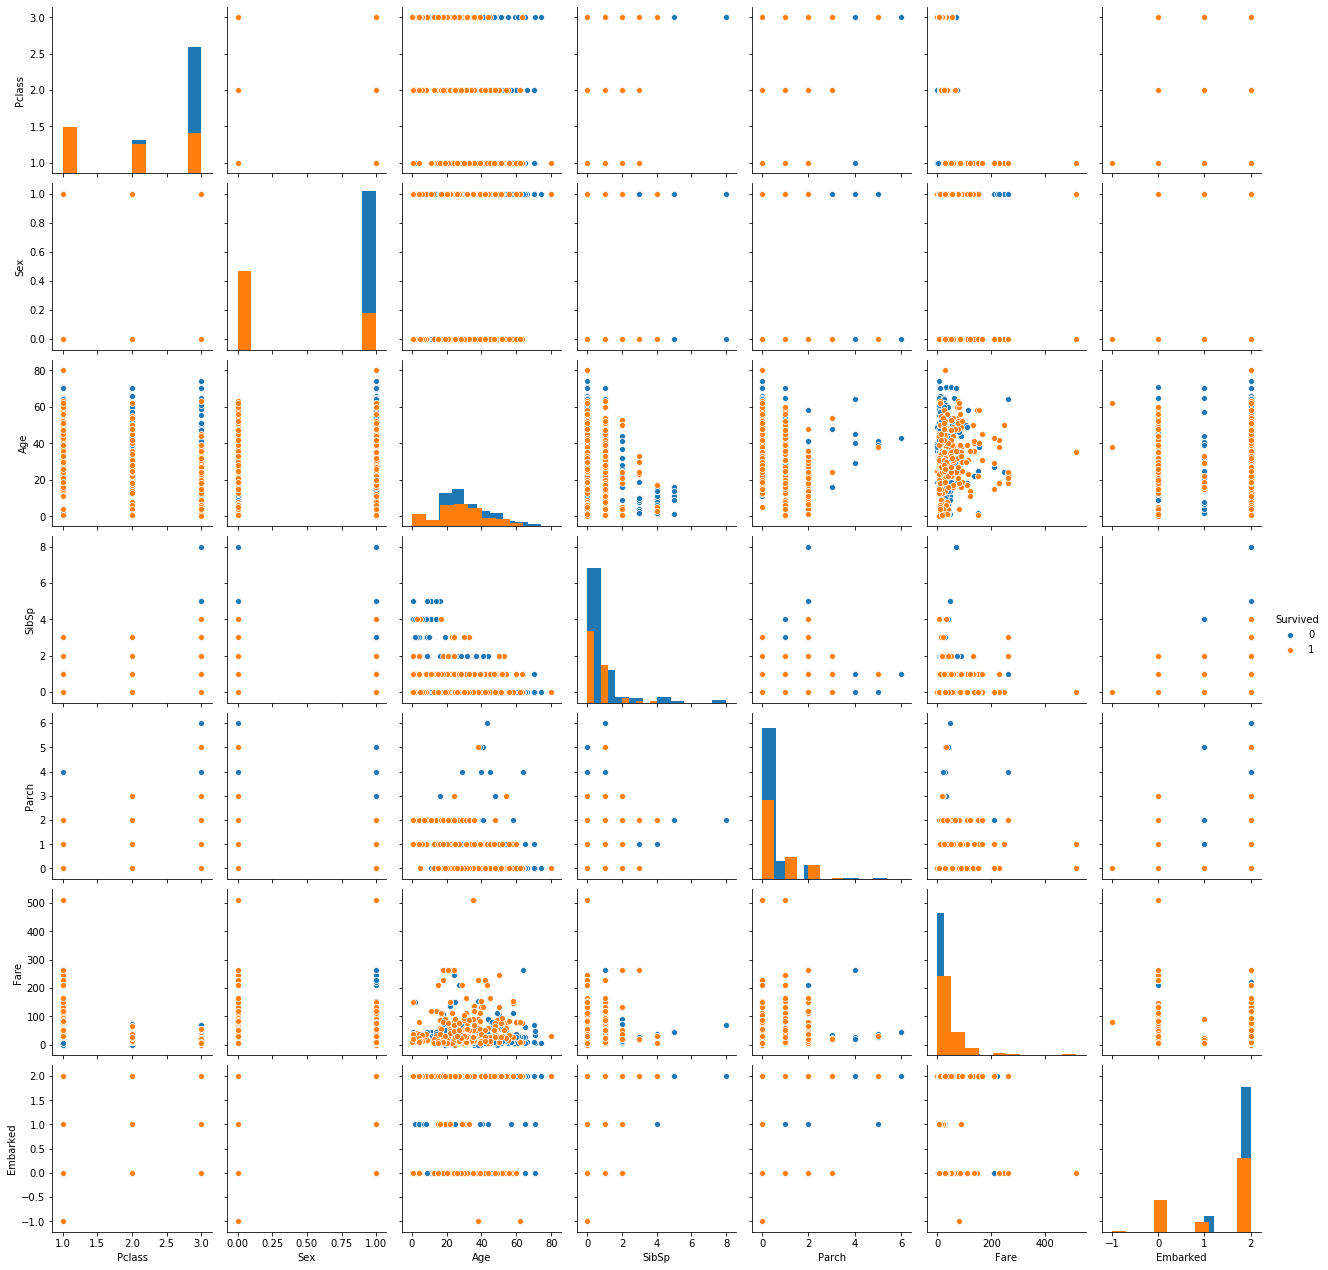

In [97]:
sns.pairplot(transformed_data, hue="Survived", diag_kind="hist")

### 傾向メモ

上記グラフから分析
* Pclassでは生存率に関しては３クラス均等だが、死亡率に関しては「3：下層クラス」が高く、その次に「2：中級クラス」が高い
* Sexでは「1：男性」が死亡率高い
* SIbSp, Parchでは、複数人で搭乗していれば生存率、死亡率は共に約50%。単身で搭乗していた場合、生存率はおおよそ33％、死亡率はおおよそ66%(目測)
* Embarkedでは「2：S = Southampton」で死亡率が高い（そもそもここで搭乗した人数が多いが）

## SibSpとParch拡大

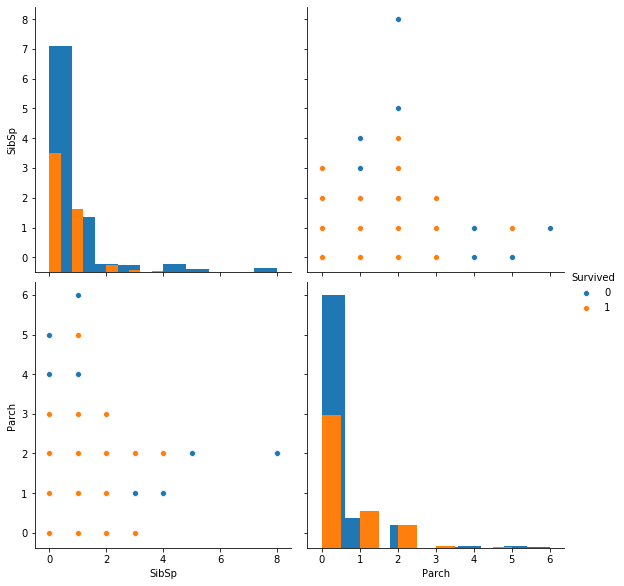

In [107]:
sns.pairplot(transformed_data, vars=['SibSp', 'Parch'], hue="Survived", diag_kind="hist", height=4)

やはり単身者は生存率が低い

SibSp, Parchを統合する（FamilySizeカラム作成）

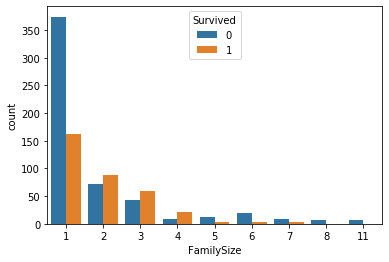

In [99]:
transformed_data["FamilySize"]  = transformed_data["SibSp"] + transformed_data["Parch"] + 1
sns.countplot(transformed_data['FamilySize'],hue=transformed_data['Survived'])

こう見ると、単身者に生存率が低いのはイメージできるが、5人以上の家族参加グループも生存率が低い

多すぎると逆に動きにくいのか？これは特徴として効いてきそう

## 重なっているパラメータを広げてプロット

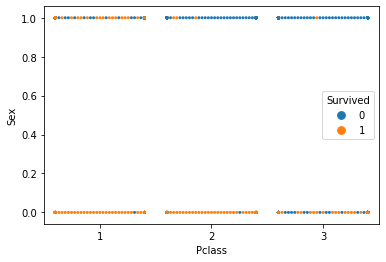

In [100]:
sns.swarmplot(data=transformed_data, x='Pclass', y='Sex', hue="Survived", size=3)

* こう見ると男性と比べて女性の生存率は高い
* 女性は下層クラスでのみ死亡者がちらほら。一方で男性は上級クラスで生存者がちらほらいる程度。
    * Pclassの2,3(中級、下層)で生き残った男性はどんな人たち？
    * Pclassの1. 2でなくなった女性はどんな人たち？

In [101]:
male_in_Pclass3_data = transformed_data.query('Sex == 1 & Pclass == 3')
female_in_Pclass1_data = transformed_data.query('Sex == 0 & Pclass == 1')

## 下級クラスで生き残った男性は何者？

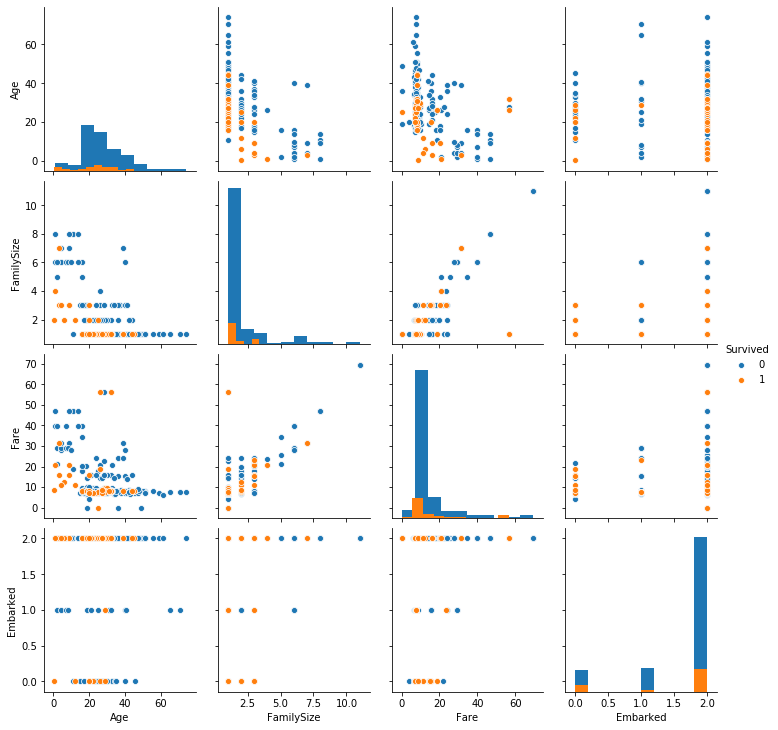

In [102]:
sns.pairplot(male_in_Pclass3_data, hue="Survived", vars=['Age','FamilySize', 'Fare','Embarked'], diag_kind="hist")

In [103]:
survived_male_in_Pclass3_data = male_in_Pclass3_data.query('Survived == 1')

In [104]:
survived_male_in_Pclass3_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
36,1,3,1,NaN,0,0,7.2292,0,1
65,1,3,1,NaN,1,1,15.2458,0,3
74,1,3,1,32.00,0,0,56.4958,2,1
81,1,3,1,29.00,0,0,9.5000,2,1
107,1,3,1,NaN,0,0,7.7750,2,1
125,1,3,1,12.00,1,0,11.2417,0,2
127,1,3,1,24.00,0,0,7.1417,2,1
146,1,3,1,27.00,0,0,7.7958,2,1
165,1,3,1,9.00,0,2,20.5250,2,3
204,1,3,1,18.00,0,0,8.0500,2,1


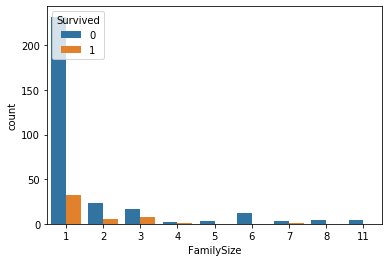

In [111]:
sns.countplot(male_in_Pclass3_data['FamilySize'],hue=male_in_Pclass3_data['Survived'])

## 上級クラスで生き残れなかった女性はどんな人？

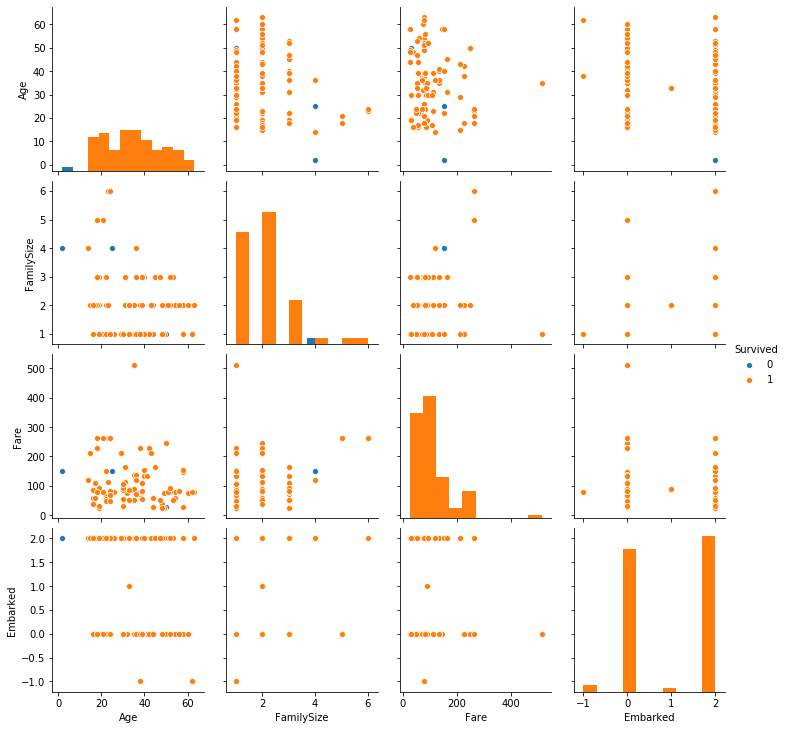

In [106]:
sns.pairplot(female_in_Pclass1_data, hue="Survived", vars=['Age','FamilySize', 'Fare','Embarked'], diag_kind="hist")

In [108]:
unsurvived_female_in_Pclass1_data = female_in_Pclass1_data.query('Survived == 0')

In [109]:
unsurvived_female_in_Pclass1_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize
177,0,1,0,50.0,0,0,28.7125,0,1
297,0,1,0,2.0,1,2,151.5500,2,4
498,0,1,0,25.0,1,2,151.5500,2,4


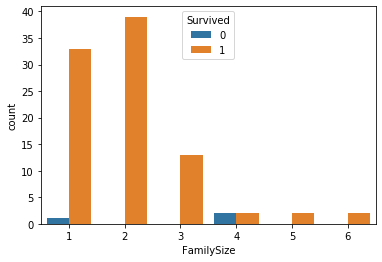

In [112]:
sns.countplot(female_in_Pclass1_data['FamilySize'],hue=female_in_Pclass1_data['Survived'])